In [ ]:
## making all essential imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Input
from keras.layers import Embedding

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
# load data and create vocabulary by using the recipe dictionary
data = np.load('simplified-recipes-1M.npz', allow_pickle=True)
recipes = data['recipes']
ingredients = data['ingredients']

recipes = [[ingredients[i] for i in recipe] for recipe in recipes]

tokens_list = list(recipes)
vocabulary = []
for sentence in tokens_list:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [ ]:
vocabulary

['basil leaves',
 'focaccia',
 'leaves',
 'mozzarella',
 'pesto',
 'plum tomatoes',
 'rosemary',
 'sandwiches',
 'sliced',
 'tomatoes',
 'balsamic vinegar',
 'boiling water',
 'butter',
 'cooking spray',
 'crumbled gorgonzola',
 'currants',
 'gorgonzola',
 'grated orange',
 'kosher',
 'kosher salt',
 'orange rind',
 'parsley',
 'pine nuts',
 'polenta',
 'toasted',
 'vinegar',
 'water',
 'bottle',
 'bouillon',
 'carrots',
 'celery',
 'chicken bouillon',
 'cilantro',
 'clam juice',
 'cloves',
 'fish',
 'garlic',
 'medium shrimp',
 'olive',
 'olive oil',
 'onion',
 'pepper',
 'pepper flakes',
 'red pepper',
 'red pepper flakes',
 'salt',
 'sherry',
 'shrimp',
 'stewed tomatoes',
 'white',
 'white wine',
 'grand marnier',
 'kahlua',
 'black pepper',
 'coarse sea salt',
 'fresh lemon',
 'fresh lemon juice',
 'ground',
 'ground black pepper',
 'lemon',
 'lemon juice',
 'lime',
 'lime peel',
 'mayonaise',
 'sea salt',
 'shallots',
 'sherry wine',
 'sherry wine vinegar',
 'wine vinegar',
 'blu

In [ ]:
# setting a small context to set that near items are part of same recipe
CONTEXT_SIZE = 3
EMBEDDING_DIM = 100
ngrams = [
    (
        [vocabulary[i - j - 1] for j in range(CONTEXT_SIZE)],
        vocabulary[i]
    )
    for i in range(CONTEXT_SIZE, vocabulary_size)
]
# Print the first 2, just so you can see what they look like.
print(ngrams[:2])

vocab = set(vocabulary)
word_to_ix = {word: i for i, word in enumerate(vocab)}

[(['leaves', 'focaccia', 'basil leaves'], 'mozzarella'), (['mozzarella', 'leaves', 'focaccia'], 'pesto')]


**Approach**
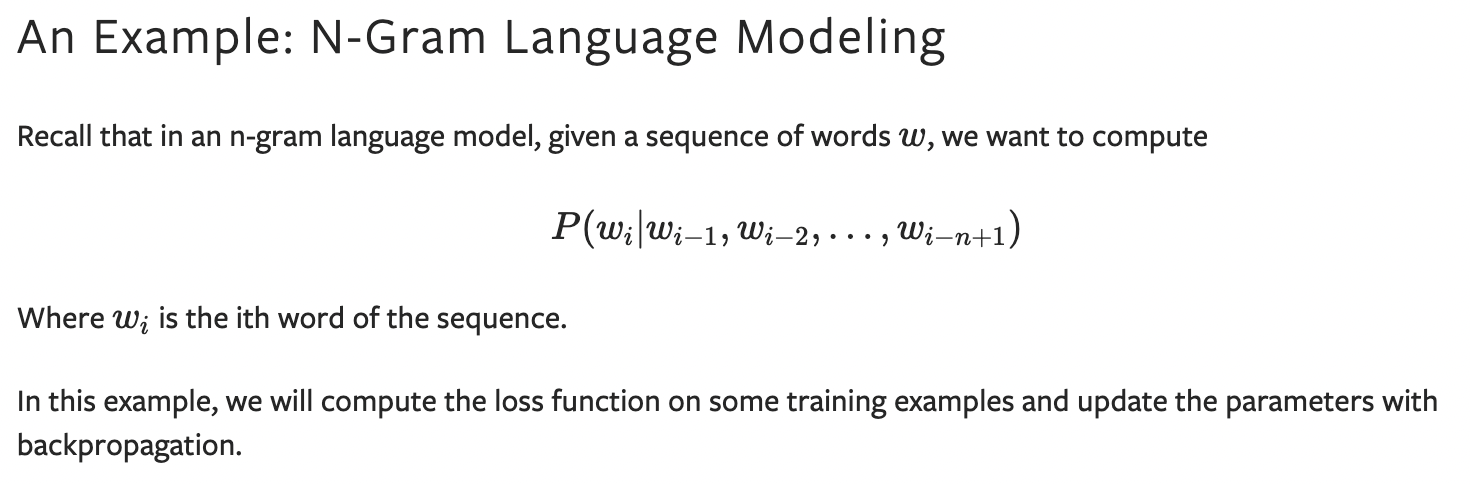

In [ ]:
# computation of loss function and backpropagation. This piece of code has been used from examples provided directly in Pytorch documentation.

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
NNmodel = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(NNmodel.parameters(), lr=0.001)

In [ ]:
for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        NNmodel.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = NNmodel(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)
# as you see, the loss decreased every iteration over the training data!

[28659.389539718628, 28436.713762760162, 28223.550121307373, 28017.219832897186, 27815.970359802246, 27616.82810974121, 27417.600298404694, 27215.911254405975, 27009.62965774536, 26797.39027929306]


In [ ]:
# this is what a sample embedding looks like
print(NNmodel.embeddings.weight[word_to_ix["pesto"]])

tensor([ 1.6434, -0.7167,  0.7797,  0.1612, -1.1058, -0.0240, -0.3587,  0.5317,
         0.0135, -0.1794,  1.0535, -0.0621, -0.0976,  0.6021,  0.0131,  1.4236,
         0.4224,  1.9507, -0.7712, -0.2062, -0.2352, -0.3627,  0.1919,  0.3451,
         0.3270,  0.2045, -1.3674, -0.0144,  0.0097, -0.7443,  0.3091,  0.6316,
         0.2870,  0.6498,  0.9687,  1.2508, -1.3722,  1.0697,  1.7511,  1.6571,
        -0.6178, -1.5010, -0.5188, -0.0117,  0.2395, -0.8734,  0.9356, -1.2812,
        -0.5213, -1.5171,  0.3595,  0.6328, -0.7247,  2.4298,  1.4502,  0.2942,
        -1.2463, -0.6138, -0.4922,  0.1745, -1.5313, -1.8215, -0.8105,  0.6504,
         0.0102,  0.1911, -0.2091,  1.9725, -0.5727, -1.2327, -2.0233, -0.1686,
         0.4239,  0.4644, -0.6157, -0.7742, -0.4491, -0.3048,  1.7480,  1.2935,
         1.6849,  0.3945, -2.4096,  2.4102,  1.2001,  2.0505,  0.9669,  0.0519,
        -1.7293, -0.9855,  1.0841,  0.4618,  1.4922, -0.1839, -1.0145,  0.8495,
        -1.1911,  0.1368, -0.8439, -0.52

In [ ]:
# settining up our entire training data using vocabulary
train_len = 3
text_sequences = []
for i in range(train_len,len(vocabulary)):
  seq = vocabulary[i-train_len:i]
  text_sequences.append(seq)
text_sequences 

[['basil leaves', 'focaccia', 'leaves'],
 ['focaccia', 'leaves', 'mozzarella'],
 ['leaves', 'mozzarella', 'pesto'],
 ['mozzarella', 'pesto', 'plum tomatoes'],
 ['pesto', 'plum tomatoes', 'rosemary'],
 ['plum tomatoes', 'rosemary', 'sandwiches'],
 ['rosemary', 'sandwiches', 'sliced'],
 ['sandwiches', 'sliced', 'tomatoes'],
 ['sliced', 'tomatoes', 'balsamic vinegar'],
 ['tomatoes', 'balsamic vinegar', 'boiling water'],
 ['balsamic vinegar', 'boiling water', 'butter'],
 ['boiling water', 'butter', 'cooking spray'],
 ['butter', 'cooking spray', 'crumbled gorgonzola'],
 ['cooking spray', 'crumbled gorgonzola', 'currants'],
 ['crumbled gorgonzola', 'currants', 'gorgonzola'],
 ['currants', 'gorgonzola', 'grated orange'],
 ['gorgonzola', 'grated orange', 'kosher'],
 ['grated orange', 'kosher', 'kosher salt'],
 ['kosher', 'kosher salt', 'orange rind'],
 ['kosher salt', 'orange rind', 'parsley'],
 ['orange rind', 'parsley', 'pine nuts'],
 ['parsley', 'pine nuts', 'polenta'],
 ['pine nuts', 'pole

In [ ]:
# seperating training sequences and labels. The first 2 ingredients are being used to predict the third. Think of this as X_train and Y_train
train_sequence = [[NNmodel.embeddings.weight[word_to_ix[ingredient]].detach().numpy() for ingredient in sequence[:2]] for sequence in text_sequences]
train_sequence

label_sequence = [[NNmodel.embeddings.weight[word_to_ix[ingredient]].detach().numpy() for ingredient in sequence[2:]] for sequence in text_sequences]
label_sequence

[[array([-1.3001689 , -1.1751701 , -1.1725693 ,  0.30844903,  1.4035999 ,
          0.6299913 ,  0.99298376,  1.6994423 , -0.87794054,  0.92210245,
         -0.38287497,  0.669515  ,  1.3084038 , -0.07494172, -0.5433117 ,
         -0.70944965,  1.295602  ,  1.2796594 , -0.63458127,  0.20954408,
         -0.29420638, -1.6280586 ,  1.2066107 ,  0.6246333 , -0.8175883 ,
          2.841674  ,  1.3576186 , -0.8520524 , -0.38862905, -2.6332047 ,
         -0.10921188,  0.14124158,  0.40183362, -0.78064835,  2.0409322 ,
          0.86600417,  0.63049746, -0.94231045, -0.44687453,  1.2015852 ,
          1.091647  , -1.3462502 ,  0.37839952,  0.34753734, -0.3536823 ,
         -1.2633213 ,  1.3430792 ,  1.5799187 ,  0.8327589 , -0.6580023 ,
          2.1690283 , -1.234268  , -0.45569468, -1.3041323 ,  0.3572    ,
         -0.8222116 ,  2.6837907 ,  0.5971032 ,  0.41990665, -0.60062426,
          0.24450581,  0.63820976,  0.6449678 , -0.3173648 , -1.1787817 ,
         -0.31368548,  1.3609103 , -0.

In [ ]:
train_inputs = np.array(train_sequence)
train_targets = np.array(label_sequence)
train_targets = train_targets.reshape(train_targets.shape[0],train_targets.shape[2])
train_targets.shape, train_inputs.shape

((3497, 100), (3497, 2, 100))

In [ ]:
# # setting up the neural net with 2 LSTM and 2 Dense Layers
model = Sequential()
model.add(Input(shape=(2,100)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(50,activation='relu'))
model.add(Dense(100, activation='relu'))
# compiling the network

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    name="Adam"
)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 100)            80400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 100)               5100      
                                                                 
Total params: 118,250
Trainable params: 118,250
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # model training on inputs 
history = model.fit(train_inputs,train_targets,epochs=500)

Epoch 1/500
110/110 [==============================] - 5s 8ms/step - loss: 1.0004 - accuracy: 0.0063
Epoch 2/500
110/110 [==============================] - 1s 9ms/step - loss: 0.9992 - accuracy: 0.0166
Epoch 3/500
110/110 [==============================] - 1s 8ms/step - loss: 0.9974 - accuracy: 0.0229
Epoch 4/500
110/110 [==============================] - 1s 8ms/step - loss: 0.9942 - accuracy: 0.0269
Epoch 5/500
110/110 [==============================] - 1s 9ms/step - loss: 0.9895 - accuracy: 0.0300
Epoch 6/500
110/110 [==============================] - 1s 8ms/step - loss: 0.9830 - accuracy: 0.0409
Epoch 7/500
110/110 [==============================] - 1s 8ms/step - loss: 0.9756 - accuracy: 0.0443
Epoch 8/500
110/110 [==============================] - 1s 8ms/step - loss: 0.9674 - accuracy: 0.0503
Epoch 9/500
110/110 [==============================] - 1s 8ms/step - loss: 0.9589 - accuracy: 0.0589
Epoch 10/500
110/110 [==============================] - 1s 9ms/step - loss: 0.9507 - accura

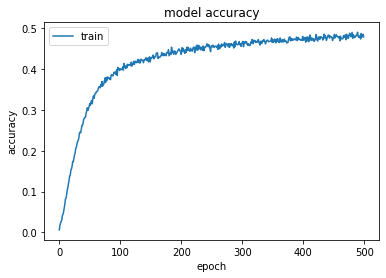

In [ ]:
# plotting training accuracy
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

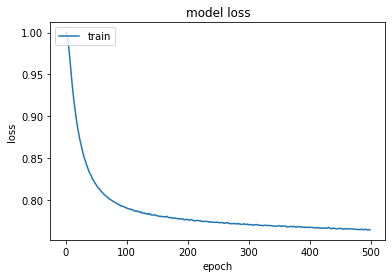

In [ ]:
# plotting training loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
# getting our recommendations
input_text = ['basil leaves', 'pasta']
input_vector = [NNmodel.embeddings.weight[word_to_ix[idx]].detach().numpy() if idx in vocabulary else np.zeros((100,)) for idx in input_text]
if len(input_vector)!=2:
  while len(input_vector)!=2:
    input_vector.append(np.zeros((100,)))
input_vector = np.array([input_vector])

#making predictions using model
output_vector = model.predict(input_vector)

# finding the most similar vector to output vector to generate top 10 suggestions
label_sequence = np.array(label_sequence)
reshaped_labels = np.array(label_sequence).reshape([label_sequence.shape[0],label_sequence.shape[2]])
import sklearn
from sklearn.metrics import pairwise
sim_array = sklearn.metrics.pairwise.cosine_similarity(reshaped_labels, Y=output_vector, dense_output=True).reshape([reshaped_labels.shape[0],])
top_10 = np.argsort(sim_array)[-10:][::-1]
print("Top 10 ingredient suggestions:")
for i in top_10:
  print(vocabulary[i], sim_array[i])

Top 10 ingredient suggestions:
cooking oil 0.38277784
bay 0.35675192
yellow 0.33743054
chicken meat 0.31953725
guava 0.31536168
ground sage 0.3141939
hazelnut oil 0.3109538
pork shoulder butt 0.3070619
navel oranges 0.2855985
tasso 0.28520977
